# N.B.

After this notebook, we will switch back to Julia language.
The reasons are threefold:

* Julia provides a decent performance boost for free;
* Julia is the main language at LakeTide, technical support has neither distance nor latency;
* Julia has better support for OpenStreetMap, which is needed for future traffic simulation.

Switching from Julia to Python was not a bad idea per se;
Python plus Networkx worked quite well in the last two weeks as
the tool set to conduct the proof of concepts; currently, new
needs demand new set of tools.

# Heads-Up

In this notebook, we scale up the graph to 1000 nodes;
this makes the size of samples around one billion, which
makes it impossible to be generated and further augmented.

The way to cope with that is to randomly sample pairs of nodes
and generate training data from them. Idealy, the training size
before augmentation is around one millon.

The meaning of this stocastic manner is twofold.
* it reduced the complexity of training set generation massively
* this is a decent test to see if the model is truly able to generalize

# Problems

The algorithm does not seem to work well with a graph
of 1000 nodes, which is somehow disappointing.

Possible reasons are the following:

* The model is not powerful enough to learn the graph;
* The stochastic sampling of training data does not show the model the big picture, i.e.,
the model gets confused by the edges it has never seen before;

* The training sample should allow the model the take steps back, i.e., for each sample
path, the parent nodes should be included;

However, after deeper analysis, we tend to believe that it is certain properties of 
the graph that make the current model much harder to be trained and to infer. ("./Mar_19/")

# Make it "smarter" TODO

* Detect dead loop;
* <del>Include the parent nodes for training</del> (**tests show that this makes the model harder to be trained and less "intelligent"**)
* Randomize the input vectors duing inference
* Add a new heuristic, i.e., for each first order edge, 
look ahead a certain number of steps and use a greedy
strategy to always go with the edge with the largest centrality;
(adding the last node might help, geo-location, cos-distance, Euclidean-distance etc.)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-22 10:19:11.650693. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [12]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=100,\
                          min_out_degree=2,\
                          max_out_degree=4,\
                          weight_min=WEIGHT_MIN,
                          weight_max=WEIGHT_MAX,
                          grid_size=20000):
    
    G = nx.Graph()
    
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-22 10:20:42.540986. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [47]:
G = nx.read_gpickle("./Mar_19/graph.pickle")
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

4
2
1000
1759


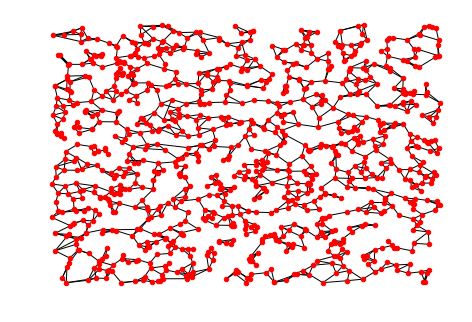

In [48]:
plot_g(G, with_labels=False, node_size=20, font_size=4)

In [120]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def find_central_edge_greedy(G, start, depth=3):
    
    cur_node = start
    path = [cur_node]
    
    centrality_sum = 0.0
    
    for d in range(depth + 1):
        
        edge_tuples = map(lambda e:(e[0], e[1], G.get_edge_data(e[0], e[1])['centrality']),\
                  G.edges(cur_node))
        
#         print(cur_node)
#         print(edge_tuples)
#         print('')
        chosen_edge = max(edge_tuples, key=lambda t:t[2])
        
        assert cur_node == chosen_edge[0]
        cur_node = chosen_edge[1]
        
        # No point of getting trapped
        # in a dead loop;
        # just break out
        if cur_node in path:
            break
        
        centrality_sum += chosen_edge[2]
        path.append(cur_node)
    
    return centrality_sum

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, sample_size_lower_bound=500, frequent=100):
    
    X = []
    y = []
    
    pair_path_dict = dict()
    
    selected_pairs = []
    sample_cnt = 0
    num_of_nodes = G.number_of_nodes()
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        selected_pairs.append((src, dst))
        
        for src, dst in [(src, dst), (dst, src)]:
            try:
                path = nx.dijkstra_path(G, src, dst)
                # TODO record all paths for later use
                
            except NetworkXNoPath:
                print("No path between %d and %d" % (src, dst))
                break
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

#                 print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                X.append(encode_edges(G, parent_node, cur_node, src, dst))
                y.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
                sample_cnt += 1
                
                if sample_cnt % frequent == 0:
                    print("Collected %d samples." % (sample_cnt))
        
        if sample_cnt >= sample_size_lower_bound:
            break
        
    return X, y, selected_pairs, pair_path_dict

In [ ]:
features, labels, selected_pairs, pair_path_dict = generate_stochastic_dataset(G, \
                                                               sample_size_lower_bound=250000, \
                                                               frequent=30000)
print("%d pairs are selected" % (len(selected_pairs)))

In [68]:
print(len(labels))
print(len(selected_pairs))
print(len(pair_path_dict))

250006
4262
8144


In [69]:
pair_path_len_dict = map(lambda d: (d[0], len(d[1])), pair_path_dict.items())
max_selected_path_len = max(pair_path_len_dict, key=lambda d:d[1])
min_selected_path_len = min(pair_path_len_dict, key=lambda d:d[1])

print max_selected_path_len
print min_selected_path_len

((824, 594), 80)
((403, 394), 2)


In [70]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
            if cnt % print_freq == 0:
                print("Processed %d samples" % (cnt))
            
    return X_aug, y_aug

In [71]:
X, y = augment_dataset(features, labels,\
                       augmentation_index=20, \
                       print_freq=600000)
print(X.shape)
print(y.shape)

Processed 600000 samples
Processed 1200000 samples
Processed 1800000 samples
Processed 2400000 samples
Processed 3000000 samples
Processed 3600000 samples
Processed 4200000 samples
Processed 4800000 samples
(5000120, 28)
(5000120,)


In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000096, 28)
(4000096,)
(1000024, 28)
(1000024,)


In [73]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)

In [74]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=1024)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=512)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [75]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 6000),
              epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=10) 

In [78]:
# acc = mx.metric.Accuracy()
# train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size=batch_size)
# model.score(train_iter, acc)
# print('Acc on training set %f' % acc.get()[1])

# acc = mx.metric.Accuracy()
# test_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)
# model.score(test_iter, acc)
# print('Acc on test set %f' % acc.get()[1])

acc = mx.metric.Accuracy()
all_iter = mx.io.NDArrayIter(X, y, batch_size=batch_size)
model.score(all_iter, acc)
print('Acc on all %f' % acc.get()[1])

Acc on all 0.959815


In [121]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
#         print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
    
#     if neighbor in path:
#         print("Duplicated nodes, randomizing next node")
#         avaliable_neighbors = filter(lambda d: d >= 0 and d != neighbor, input_vec[:, -1])

#         if len(avaliable_neighbors) == 0:
#             print("Duplicated nodes, no other nodes available")
#         else:
#             neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
        
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, model=None, invalid_path_threshold=100):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, path, parent_node, cur_node, src, dst, model)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [122]:
# G = generate_low_degree_g()
def calc_statistics(G, pair_path_dict, num_to_test=100):
    found_cnt = 0
    opt_path_cnt = 0
    
    def calc_dot_dist(p1, p2):
        return np.dot(p1, p2)

    def calc_geo_dist(p1, p2):

        p_1 = np.array(p1)
        p_2 = np.array(p2)

        return np.sqrt(np.sum((p_1 - p_2)**2))

    def heuristic(node, dst):

        x_src = G.nodes[src]['x']
        y_src = G.nodes[src]['y']
        x_dst = G.nodes[dst]['x']
        y_dst = G.nodes[dst]['y']
        x_node = G.nodes[node]['x']
        y_node = G.nodes[node]['y']

        dist_src_2_dst = calc_geo_dist((x_src, y_src), (x_dst, y_dst))
        dot_src_2_node = calc_dot_dist((x_node-x_src, y_node-y_src), (x_dst-x_src, y_dst-y_src))
        ret = dist_src_2_dst - (dot_src_2_node) / dist_src_2_dst

        return ret
    
    pairs = pair_path_dict.keys()
    random.shuffle(pairs)
    
    for src, dst in pairs[:num_to_test]:

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(src, dst)]
        
        if not found:
            
#             print("The model is unable to find a path between %d and %d" % (src, dst))
            
#             plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
            
#             print("Dijkstra path :", dijkstra_path)
# #             print("NN path :", nn_path)
#             print('')
            continue

        found_cnt += 1
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1

        else:
            print("The model is able to find a different path between %d and %d" % (src, dst))
            plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
#             pass
# #             astar_path = nx.astar_path(G, src, dst, heuristic=heuristic)
#             print('Printing all paths for reference:')
            print("Dijkstra path :", dijkstra_path)
# #             print("A star path :", astar_path)
            print("NN path :", nn_path)
            print('')

    return found_cnt, opt_path_cnt

In [123]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, pair_path_dict=pair_path_dict, num_to_test=num_to_test)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))

The model is able to find a different path between 610 and 378


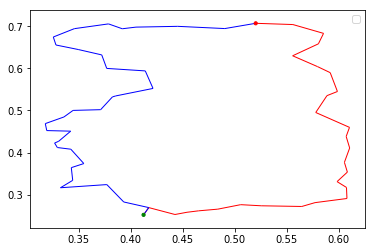

('Dijkstra path :', [610, 709, 212, 86, 12, 505, 311, 82, 694, 951, 259, 247, 635, 358, 698, 39, 598, 245, 708, 615, 826, 235, 566, 953, 888, 936, 882, 378])
('NN path :', [610, 812, 643, 908, 356, 625, 680, 568, 731, 726, 897, 308, 489, 455, 261, 292, 10, 584, 745, 863, 629, 16, 383, 498, 380, 23, 407, 121, 151, 138, 703, 471, 882, 378])

The model is able to find a different path between 696 and 330


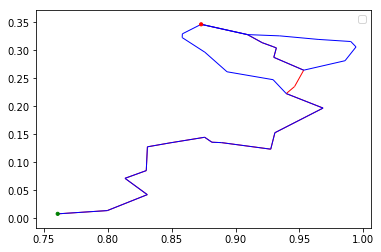

('Dijkstra path :', [696, 310, 385, 283, 162, 907, 840, 217, 7, 816, 919, 516, 278, 144, 275, 830, 289, 769, 359, 170, 421, 330])
('NN path :', [696, 310, 478, 658, 462, 413, 941, 840, 907, 162, 283, 385, 310, 696, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830, 289, 769, 359, 170, 421, 330])

The model is able to find a different path between 36 and 578


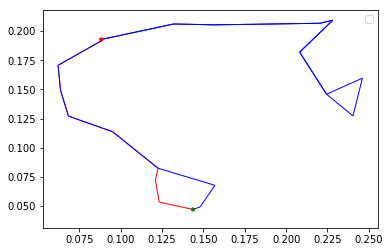

('Dijkstra path :', [36, 540, 554, 69, 41, 616, 424, 326, 72, 578])
('NN path :', [36, 974, 976, 575, 364, 969, 431, 434, 825, 431, 969, 364, 575, 976, 974, 36, 540, 554, 69, 41, 616, 424, 732, 631, 578])

The model is able to find a different path between 559 and 716


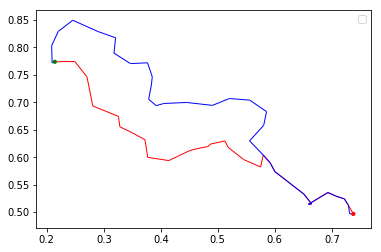

('Dijkstra path :', [559, 123, 428, 213, 866, 423, 771, 949, 88, 311, 505, 736, 263, 456, 723, 688, 488, 497, 185, 489, 308, 897, 726, 731, 568, 823, 967, 918, 716])
('NN path :', [559, 77, 123, 428, 213, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 643, 908, 356, 625, 972, 357, 973, 316, 204, 368, 673, 657, 343, 752, 225, 716])

The model is able to find a different path between 380 and 803


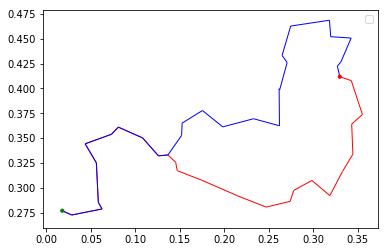

('Dijkstra path :', [380, 23, 407, 121, 151, 138, 564, 916, 228, 236, 534, 57, 375, 172, 52, 461, 76, 637, 623, 662, 30, 672, 31, 85, 67, 803])
('NN path :', [380, 498, 383, 16, 629, 863, 929, 47, 248, 417, 468, 116, 363, 572, 574, 457, 990, 461, 76, 637, 623, 662, 30, 672, 31, 85, 67, 803])



The model is able to find a different path between 818 and 760


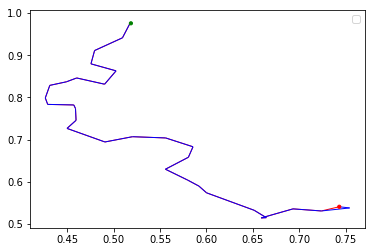

('Dijkstra path :', [818, 922, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 851, 422, 619, 671, 13, 409, 262, 429, 18, 373, 95, 264, 32, 984, 682, 760])
('NN path :', [818, 707, 922, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 851, 422, 619, 671, 13, 409, 262, 429, 18, 373, 95, 264, 32, 984, 682, 760])



The model is able to find a different path between 129 and 943


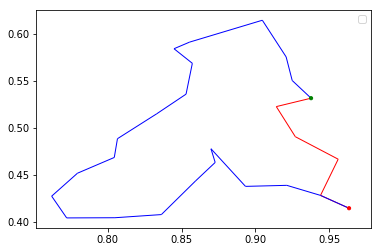

('Dijkstra path :', [129, 435, 425, 604, 746, 943])
('NN path :', [129, 435, 269, 850, 640, 459, 819, 66, 438, 664, 391, 384, 338, 168, 515, 334, 372, 354, 965, 856, 167, 606, 943])



The model is able to find a different path between 12 and 830


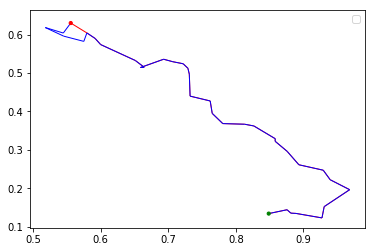

('Dijkstra path :', [12, 505, 311, 88, 949, 771, 423, 866, 213, 428, 123, 77, 904, 391, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830])
('NN path :', [12, 220, 456, 263, 736, 505, 311, 88, 949, 771, 423, 866, 213, 428, 123, 77, 904, 391, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830])



The model is able to find a different path between 710 and 479


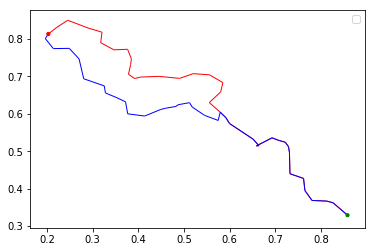

('Dijkstra path :', [710, 343, 657, 673, 368, 204, 316, 973, 357, 972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 505, 311, 88, 949, 771, 423, 866, 213, 428, 123, 77, 904, 391, 111, 585, 780, 711, 479])
('NN path :', [710, 747, 716, 918, 967, 823, 568, 731, 726, 897, 308, 489, 185, 497, 488, 688, 723, 456, 263, 736, 505, 311, 88, 949, 771, 423, 866, 213, 428, 123, 77, 904, 391, 111, 585, 780, 711, 479])

The model is able to find a different path between 483 and 88


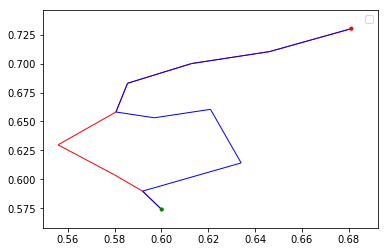

('Dijkstra path :', [483, 714, 273, 212, 86, 12, 505, 311, 88])
('NN path :', [483, 714, 273, 212, 86, 761, 654, 29, 311, 88])

The model is able to find a different path between 764 and 185


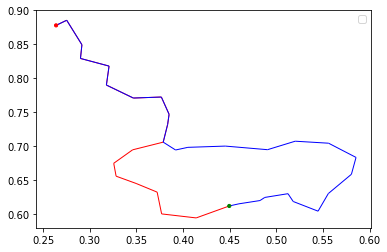

('Dijkstra path :', [764, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 680, 568, 731, 726, 897, 308, 489, 185])
('NN path :', [764, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 220, 456, 723, 688, 488, 497, 185])

The model is able to find a different path between 141 and 855


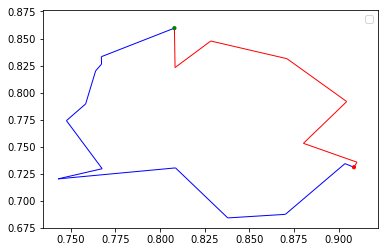

('Dijkstra path :', [141, 792, 97, 75, 556, 542, 128, 855])
('NN path :', [141, 156, 678, 510, 839, 827, 796, 439, 810, 302, 274, 328, 855])

The model is able to find a different path between 913 and 981


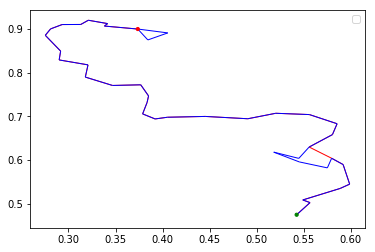

('Dijkstra path :', [913, 955, 351, 509, 44, 198, 256, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 505, 311, 82, 694, 582, 239, 981])
('NN path :', [913, 133, 136, 913, 955, 351, 509, 44, 198, 256, 645, 242, 673, 368, 204, 316, 973, 357, 972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 220, 456, 263, 736, 505, 311, 82, 694, 582, 239, 981])



The model is able to find a different path between 576 and 211


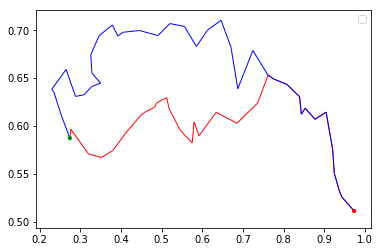

('Dijkstra path :', [576, 782, 943, 606, 167, 856, 166, 777, 701, 125, 751, 105, 756, 323, 899, 930, 29, 311, 505, 736, 263, 456, 723, 688, 488, 497, 185, 489, 112, 113, 596, 670, 211])
('NN path :', [576, 782, 943, 606, 167, 856, 166, 777, 701, 125, 751, 105, 756, 323, 983, 216, 91, 714, 273, 212, 709, 610, 812, 643, 908, 356, 625, 680, 568, 731, 726, 980, 638, 963, 538, 223, 506, 960, 211])

The model is able to find a different path between 537 and 635


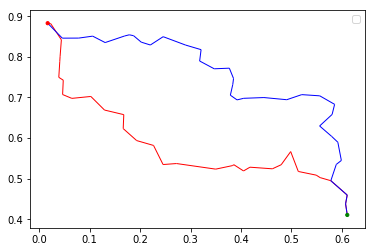

('Dijkstra path :', [537, 875, 730, 187, 737, 251, 418, 484, 985, 581, 562, 725, 145, 110, 848, 388, 946, 835, 292, 261, 705, 722, 408, 895, 2, 964, 582, 239, 951, 259, 247, 635])
('NN path :', [537, 798, 605, 102, 395, 400, 131, 475, 416, 343, 657, 673, 368, 204, 316, 973, 357, 972, 625, 356, 908, 643, 812, 610, 709, 212, 86, 12, 505, 311, 82, 694, 951, 259, 247, 635])



The model is able to find a different path between 977 and 63


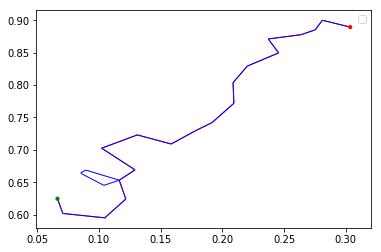

('Dijkstra path :', [977, 256, 645, 764, 987, 657, 343, 752, 225, 318, 821, 202, 164, 581, 562, 910, 704, 353, 246, 87, 63])
('NN path :', [977, 256, 645, 764, 987, 657, 343, 752, 225, 318, 821, 202, 164, 581, 562, 910, 415, 477, 192, 322, 910, 704, 353, 246, 87, 63])

The model is able to find a different path between 726 and 46


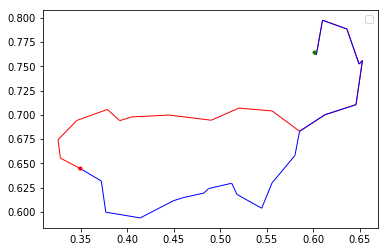

('Dijkstra path :', [726, 731, 568, 680, 625, 356, 908, 643, 812, 610, 709, 212, 273, 714, 735, 389, 507, 676, 281, 46])
('NN path :', [726, 897, 308, 489, 185, 497, 488, 688, 723, 456, 220, 12, 86, 212, 273, 714, 735, 389, 507, 676, 281, 46])

The model is able to find a different path between 870 and 469


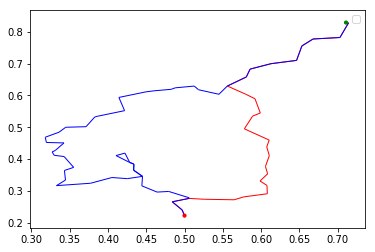

('Dijkstra path :', [870, 590, 566, 235, 826, 615, 708, 245, 598, 39, 698, 358, 635, 247, 259, 951, 694, 82, 311, 505, 12, 86, 212, 273, 714, 735, 444, 104, 622, 469])
('NN path :', [870, 590, 566, 235, 893, 628, 968, 114, 543, 458, 381, 844, 533, 766, 844, 381, 458, 543, 55, 793, 703, 138, 151, 121, 407, 23, 380, 498, 383, 16, 629, 863, 745, 584, 10, 292, 261, 455, 489, 185, 497, 488, 688, 723, 456, 220, 12, 86, 212, 273, 714, 735, 444, 104, 622, 469])

The model is able to find a different path between 352 and 967


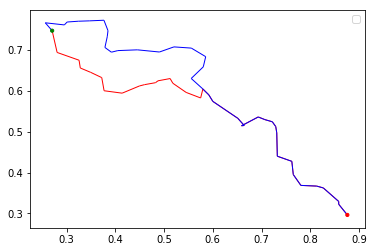

('Dijkstra path :', [352, 996, 479, 711, 780, 585, 111, 391, 904, 77, 123, 428, 213, 866, 423, 771, 949, 88, 311, 505, 736, 263, 456, 723, 688, 488, 497, 185, 489, 308, 897, 726, 731, 568, 823, 967])
('NN path :', [352, 996, 479, 711, 780, 585, 111, 391, 904, 77, 123, 428, 213, 866, 423, 771, 949, 88, 311, 505, 12, 86, 212, 709, 610, 812, 643, 908, 356, 625, 972, 357, 973, 316, 231, 157, 753, 508, 967])



The model is able to find a different path between 79 and 13


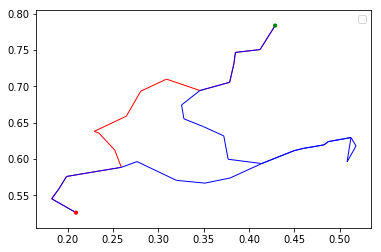

('Dijkstra path :', [79, 675, 853, 702, 848, 149, 960, 506, 223, 538, 823, 786, 680, 625, 972, 357, 137, 13])
('NN path :', [79, 675, 853, 702, 848, 149, 670, 596, 113, 112, 489, 185, 497, 488, 688, 723, 456, 286, 723, 688, 488, 497, 185, 489, 308, 897, 726, 731, 568, 680, 625, 972, 357, 137, 13])

The model is able to find a different path between 806 and 453


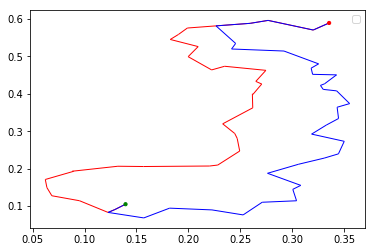

('Dijkstra path :', [806, 596, 670, 149, 848, 702, 853, 675, 79, 496, 783, 209, 929, 47, 248, 417, 468, 116, 820, 647, 534, 577, 364, 575, 976, 974, 36, 540, 554, 69, 41, 616, 424, 801, 453])
('NN path :', [806, 596, 670, 149, 848, 388, 260, 549, 520, 863, 629, 16, 383, 498, 380, 23, 407, 121, 151, 138, 564, 797, 775, 108, 58, 920, 655, 81, 270, 592, 768, 189, 254, 732, 424, 801, 453])



The model is able to find a different path between 454 and 848


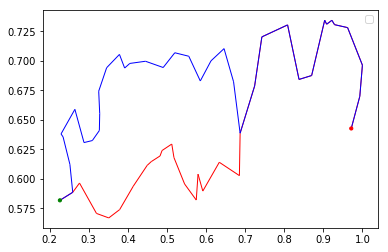

('Dijkstra path :', [454, 376, 219, 250, 294, 924, 141, 156, 678, 510, 839, 827, 983, 216, 930, 29, 311, 505, 736, 263, 456, 723, 688, 488, 497, 185, 489, 112, 113, 596, 670, 149, 848])
('NN path :', [454, 376, 219, 250, 294, 924, 141, 156, 678, 510, 839, 827, 983, 216, 91, 714, 273, 212, 709, 610, 812, 643, 908, 356, 625, 680, 568, 731, 980, 638, 963, 538, 223, 506, 960, 149, 848])



The model is able to find a different path between 212 and 749


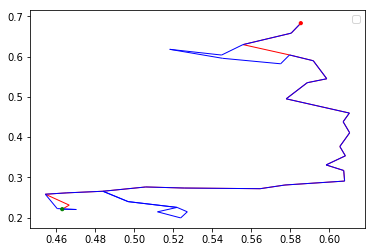

('Dijkstra path :', [212, 86, 12, 505, 311, 82, 694, 951, 259, 247, 635, 358, 698, 39, 598, 245, 708, 615, 826, 235, 566, 953, 888, 17, 749])
('NN path :', [212, 86, 12, 220, 456, 263, 736, 505, 311, 82, 694, 951, 259, 247, 635, 358, 698, 39, 598, 245, 708, 615, 826, 235, 566, 590, 550, 773, 600, 152, 550, 590, 566, 953, 888, 402, 45, 749])



The model is able to find a different path between 566 and 273


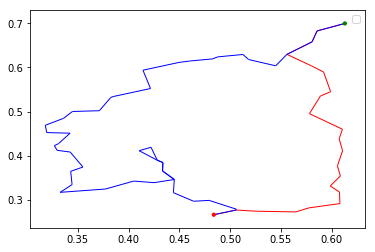

('Dijkstra path :', [566, 235, 826, 615, 708, 245, 598, 39, 698, 358, 635, 247, 259, 951, 694, 82, 311, 505, 12, 86, 212, 273])
('NN path :', [566, 235, 893, 628, 968, 114, 543, 458, 381, 844, 533, 766, 844, 381, 458, 543, 55, 793, 703, 138, 151, 121, 407, 23, 380, 498, 383, 16, 629, 863, 745, 584, 10, 292, 261, 455, 489, 185, 497, 488, 688, 723, 456, 220, 12, 86, 212, 273])



The model is able to find a different path between 693 and 345


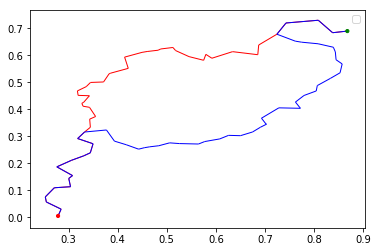

('Dijkstra path :', [693, 838, 770, 768, 592, 270, 81, 655, 920, 58, 108, 775, 797, 564, 138, 151, 121, 407, 23, 380, 498, 383, 16, 629, 863, 745, 584, 10, 292, 261, 455, 489, 185, 497, 488, 688, 723, 456, 263, 736, 505, 311, 29, 930, 216, 983, 827, 839, 510, 345])
('NN path :', [693, 838, 770, 768, 592, 270, 81, 655, 920, 58, 108, 775, 797, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 724, 536, 486, 394, 403, 636, 937, 641, 664, 391, 384, 338, 168, 515, 334, 372, 354, 125, 751, 105, 756, 323, 983, 827, 839, 510, 345])



The model is able to find a different path between 915 and 691


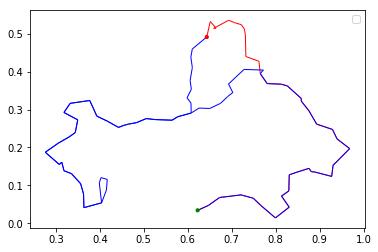

('Dijkstra path :', [915, 949, 771, 423, 866, 213, 428, 123, 77, 904, 391, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830, 289, 769, 359, 170, 421, 525, 312, 348, 59, 639, 691])
('NN path :', [915, 259, 247, 635, 358, 698, 39, 598, 245, 708, 615, 826, 235, 566, 953, 888, 936, 882, 471, 703, 138, 564, 797, 775, 108, 58, 920, 655, 93, 4, 499, 958, 180, 331, 284, 399, 154, 297, 124, 284, 331, 180, 958, 499, 4, 93, 655, 920, 58, 108, 775, 797, 564, 138, 703, 471, 882, 936, 888, 953, 566, 235, 826, 615, 708, 245, 724, 536, 486, 394, 403, 636, 937, 641, 664, 111, 585, 780, 711, 479, 996, 352, 864, 253, 7, 816, 919, 516, 278, 144, 275, 830, 289, 769, 359, 170, 421, 525, 312, 348, 59, 639, 691])



The model is able to find a different path between 885 and 437


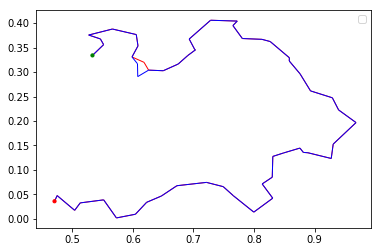

('Dijkstra path :', [885, 692, 54, 609, 526, 420, 68, 807, 691, 639, 59, 348, 312, 525, 421, 170, 359, 769, 289, 830, 275, 144, 278, 516, 919, 816, 7, 253, 864, 352, 996, 479, 711, 780, 585, 111, 664, 641, 937, 636, 403, 394, 486, 536, 724, 602, 39, 698, 358, 832, 833, 83, 227, 437])
('NN path :', [885, 692, 54, 609, 526, 420, 68, 807, 691, 639, 59, 348, 312, 525, 421, 170, 359, 769, 289, 830, 275, 144, 278, 516, 919, 816, 7, 253, 864, 352, 996, 479, 711, 780, 585, 111, 664, 641, 937, 636, 403, 394, 486, 536, 724, 245, 598, 39, 698, 358, 832, 833, 83, 227, 437])



The model is able to find a different path between 282 and 426


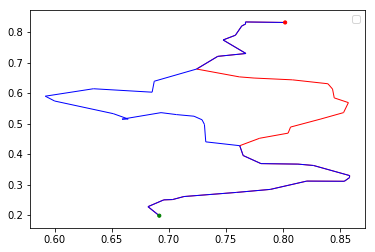

('Dijkstra path :', [282, 328, 274, 302, 810, 439, 796, 827, 983, 323, 756, 105, 751, 125, 354, 372, 334, 515, 168, 338, 384, 391, 111, 585, 780, 711, 479, 996, 494, 255, 917, 374, 728, 1, 159, 288, 426])
('NN path :', [282, 328, 274, 302, 810, 439, 796, 827, 983, 216, 930, 29, 311, 88, 949, 771, 423, 866, 213, 428, 123, 77, 904, 391, 111, 585, 780, 711, 479, 996, 494, 255, 917, 374, 728, 1, 159, 288, 426])

The model is able to find a different path between 750 and 514


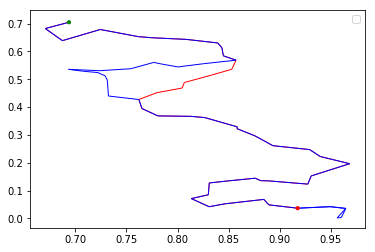

('Dijkstra path :', [750, 485, 762, 754, 170, 359, 769, 289, 830, 275, 144, 278, 516, 919, 816, 7, 253, 864, 352, 996, 479, 711, 780, 585, 111, 391, 384, 338, 168, 515, 334, 372, 354, 125, 751, 105, 756, 323, 983, 216, 91, 514])
('NN path :', [750, 620, 925, 553, 90, 925, 620, 750, 485, 762, 754, 170, 359, 769, 289, 830, 275, 144, 278, 516, 919, 816, 7, 253, 864, 352, 996, 479, 711, 780, 585, 111, 391, 904, 77, 123, 428, 213, 866, 922, 707, 178, 277, 593, 545, 372, 354, 125, 751, 105, 756, 323, 983, 216, 91, 514])



The model is able to find a different path between 939 and 618


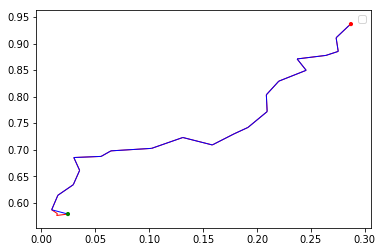

('Dijkstra path :', [939, 287, 232, 645, 764, 987, 657, 343, 752, 225, 318, 821, 202, 164, 581, 985, 599, 521, 665, 34, 901, 583, 183, 365, 618])
('NN path :', [939, 287, 232, 645, 764, 987, 657, 343, 752, 225, 318, 821, 202, 164, 581, 985, 599, 521, 665, 34, 901, 583, 618])



The model is able to find a different path between 51 and 72


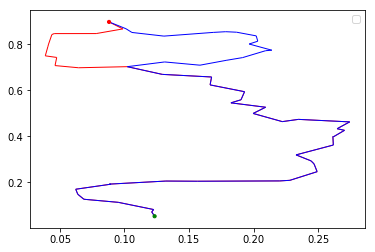

('Dijkstra path :', [51, 652, 605, 798, 730, 187, 737, 251, 418, 484, 985, 581, 562, 725, 145, 110, 853, 675, 79, 496, 783, 209, 929, 47, 248, 417, 468, 116, 820, 647, 534, 577, 364, 575, 976, 974, 36, 540, 554, 69, 41, 616, 424, 326, 72])
('NN path :', [51, 867, 102, 395, 400, 131, 475, 416, 710, 747, 716, 225, 318, 821, 202, 164, 581, 562, 725, 145, 110, 853, 675, 79, 496, 783, 209, 929, 47, 248, 417, 468, 116, 820, 647, 534, 577, 364, 575, 976, 974, 36, 540, 554, 69, 41, 616, 424, 326, 72])

The model is able to find a different path between 717 and 870


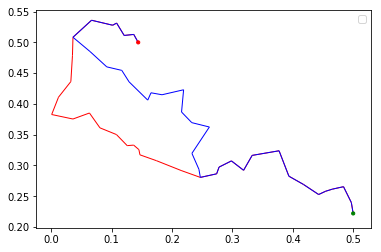

('Dijkstra path :', [717, 767, 119, 181, 594, 340, 927, 130, 854, 802, 315, 589, 392, 623, 637, 76, 461, 52, 172, 375, 57, 534, 236, 228, 916, 564, 138, 703, 471, 882, 936, 888, 953, 566, 590, 870])
('NN path :', [717, 767, 119, 181, 594, 340, 927, 934, 317, 573, 71, 611, 252, 148, 522, 889, 363, 116, 820, 647, 534, 236, 228, 916, 564, 138, 703, 471, 882, 936, 888, 953, 566, 590, 870])

The model is able to find a different path between 960 and 18


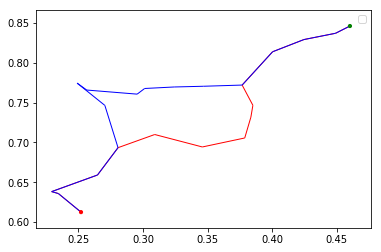

('Dijkstra path :', [960, 506, 223, 538, 823, 786, 680, 625, 972, 357, 973, 873, 8, 429, 18])
('NN path :', [960, 506, 223, 538, 823, 967, 918, 508, 753, 157, 231, 316, 973, 873, 8, 429, 18])

The model is able to find a different path between 480 and 923


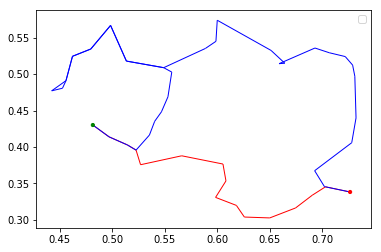

('Dijkstra path :', [480, 403, 394, 486, 536, 724, 602, 39, 698, 358, 832, 833, 360, 449, 266, 923])
('NN path :', [480, 403, 636, 937, 641, 904, 77, 123, 428, 213, 866, 423, 771, 949, 88, 82, 694, 582, 964, 2, 895, 408, 995, 447, 215, 995, 408, 895, 2, 964, 582, 239, 120, 759, 74, 171, 360, 449, 266, 923])

43 out of 50 can find path: 0.860000
9 out of 43 can find optimal path: 0.209302
9 out of 50 all paths can find optimal paths: 0.180000


In [124]:
print_paths_statistics(G, num_to_test=50, pair_path_dict=pair_path_dict)

# 9893 out of 9900 can find path: 0.999293
# 8803 out of 9893 can find optimal path: 0.889821
# 8803 out of 9900 all paths can find optimal paths: 0.889192

In [107]:
def plot_dijkstra_nn_comparison(G, dijkstra_node_list, nn_node_list):

    pos = {}

    for node in dijkstra_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    dijkstra_edge_list = []
    for idx, node in enumerate(dijkstra_node_list[:-1]):
        dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[dijkstra_node_list[0], dijkstra_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])
    
    plt.legend(loc='best')
    plt.show()

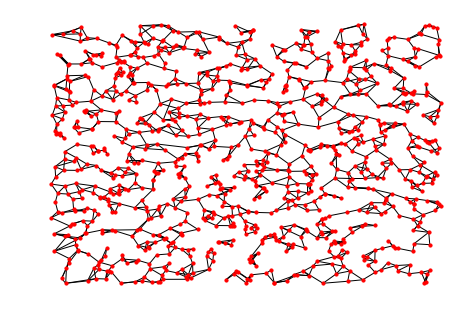

In [100]:
plot_g(G, with_labels=False, node_size=10, font_size=4)

# Some Analysis

It seems that in the cases where the model fails to find a path, the model is trapped in a dead loop; however, at the early stage of inference, the generated path is not absolute
nonsense. At some point, the model makes a dubious turn and the paths are likely to diverge.

The model has learned, to some extent, to crawl its way back to where it made a mistake and
make it to the destination; 

this is understandable since the training set sampling is bidirectional; 
more specifically, whenever a pair of nodes are selected, the paths from 
both directions are calculated and recorded; this provides the model with
the information about how to get back when the current path chosen is too
wrong.

In [ ]:
G = generate_low_degree_g(num_nodes=20, grid_size=200)

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-22 10:53:38.743320. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


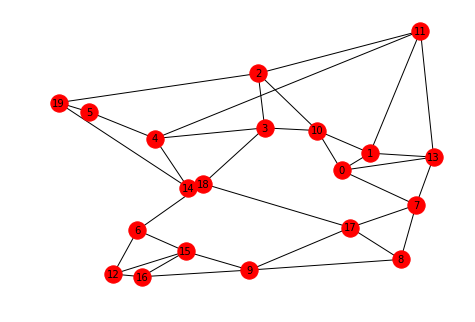

In [43]:
plot_g(G, with_labels=True, node_size=300, font_size=10)